In [1]:
import pymc as pm
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
def print_stats(index):
    
    a = 0.0
    b = 0.0
    
    pname = ''
    
    for i in index:
        a += am[i]
        b += bm[i]
        
        pname += names[i]
        pname += '_'
        
    a = np.exp(a)
    b = np.exp(b)
    
    print '{:15}'.format(pname), a, b, a / (a + b)

In [3]:
xraw = np.asarray([[1, 0],
                      [1, 1],
                      [1, 0],
                      [1, 0],
                      [1, 1]])

yraw = np.asarray([3, 2, 4, 3, 1])
zraw = np.asarray([1, 1, 0, 0, 1])

data = pandas.DataFrame(data=xraw, columns=['c1', 'c2'])
data['age'] = yraw
data['alive'] = zraw

def make_raw_article_data():

    highend_lost = np.asarray([0, 131, 257, 347, 407, 449, 483, 509])
    regular_lost = np.asarray([0, 369, 532, 618, 674, 711, 738, 759])

    # high end guys
    data_he = np.zeros((1000, 5), dtype=int)
    data_he[:, -2] = 8
    data_he[:, 0] = np.arange(data_he.shape[0])

    for age in reversed(highend_lost):
        data_he[:age, -2] -= 1

    # regular end guys
    data_re = np.zeros((1000, 5), dtype=int)
    data_re[:, -2] = 8
    data_re[:, 0] = np.arange(data_re.shape[0], 2 * data_re.shape[0])
    data_re[:, 2] = 1

    for age in reversed(regular_lost):
        data_re[:age, -2] -= 1

    data_he[:, -1][data_he[:, -2] == 8] = 1
    data_re[:, -1][data_re[:, -2] == 8] = 1

    out_data = np.concatenate((data_he, data_re), axis=0)

    data = pandas.DataFrame(data=out_data, columns=['id', 'cohort', 'category', 'age', 'alive'])

    return data

In [4]:
data = make_raw_article_data()[['category', 'age', 'alive']]
data.insert(1, 'random', np.random.randint(0, 2, (data.shape[0], 1)))

#x = data[['category', 'random']].values
x = data[['category']].values
names = ['bias'] + list(data.keys()[:-2])

In [280]:
# actual fresh data!
data = pandas.read_csv('../data/new_data.csv')


total_size = 1000
index = np.arange(data.shape[0])
np.random.shuffle(index)
index = index[:total_size]

data = data.iloc[index]
data.index = np.arange(total_size)

data['age'] = data['age'].values.astype(int)
data['alive'] = data['alive'].values.astype(int)


#x = data.values[:, :-2]#[:, :4]#[['bias', 'freshapp']]

#x = data[['creative', 'trades', 'monthly']].values
x = data[['monthly', 'creative']].values
names = ['bias'] + list(data.keys()[:-2])

In [5]:
alpha_bias = pm.Normal('alpha_bias', 0, 1, observed=False, size=1)
beta_bias = pm.Normal('beta_bias', 0, 1, observed=False, size=1)

alpha = pm.Normal('alpha', 0, 5, observed=False, size=x.shape[1])
beta = pm.Normal('beta', 0, 5, observed=False, size=x.shape[1])

In [6]:
@pm.deterministic
def _recursive_retention_stats(alpha=alpha, 
                               beta=beta,
                               alpha_bias=alpha_bias, 
                               beta_bias=beta_bias,
                               num_periods=data.age.values,
                               features=x):
    """
    A function to calculate the expected probabilities recursively.
    Using equation 7 from [1] and the alpha and beta coefficients
    obtained by training this model, it computes P(T = t) recursively,
    returning a list with all values.
    Survival function recursive calculation. Using equation 7 from [1]
    and the alpha and beta coefficients obtained by training this
    model, it computes S(T = t) recursively, returning a list of all
    computed values.. To do so it must first invoke the function
    P_T_is_t calculate the monthly churn rates for the given time
    window, and then use it to compute the survival curve recursively.
    :param alpha: float
        The distribution for the alpha parameter.
    :param beta: float
        The distribution for the beta parameter.
    :param num_periods: Int
        The number of periods for which the probability of churning
        should be computed.
    :return: (list, list)
        A list with probability of churning for all periods from month
        zero to num_periods.
    """
    stats = np.zeros((num_periods.shape[0], 2))
    
    for entry, vals in enumerate(zip(num_periods, features)):
        
        period, predictors = vals
        
        # get coeffs from combinaitons
        a = np.exp(sum(alpha_bias + predictors * alpha))
        b = np.exp(sum(beta_bias + predictors * beta))
        
        p_old = None
        p_new = a / (a + b)
        
        s_old = 1
        s_new = s_old - p_new

        for t in range(2, period + 1):
            
            # New values for old values
            p_old = p_new
            s_old = s_new
            
            # Compute latest p value and append
            p_new = (b + t - 2.) / (a + b + t - 1.) * p_old

            # use the most recent appended p value to keep building s
            s_new = s_old - p_new

        stats[entry][0] = p_new
        stats[entry][1] = s_old

    return stats

In [7]:
global_bool_mask = np.zeros((x.shape[0], 2), dtype=bool)
global_bool_mask[:, 1][data.alive.values==1] = True
global_bool_mask[:, 0][data.alive.values==0] = True

In [8]:
@pm.observed
def retention_rates(stats=_recursive_retention_stats,
                    value=data.alive.values):
    
    def logp(stats, value):

        #bool_mask = np.zeros(stats.shape, dtype=bool)
        #bool_mask[:, 1][value==1] = True
        #bool_mask[:, 0][value==0] = True
        
        return np.log(stats[global_bool_mask]).sum()

In [9]:
model = pm.Model([alpha, beta, alpha_bias, beta_bias, 
                  _recursive_retention_stats, retention_rates])
mcmc = pm.MCMC(model)

In [10]:
mcmc.sample(5e4, 5e3, thin=1)

 [-----------------100%-----------------] 50000 of 50000 complete in 6054.7 sec

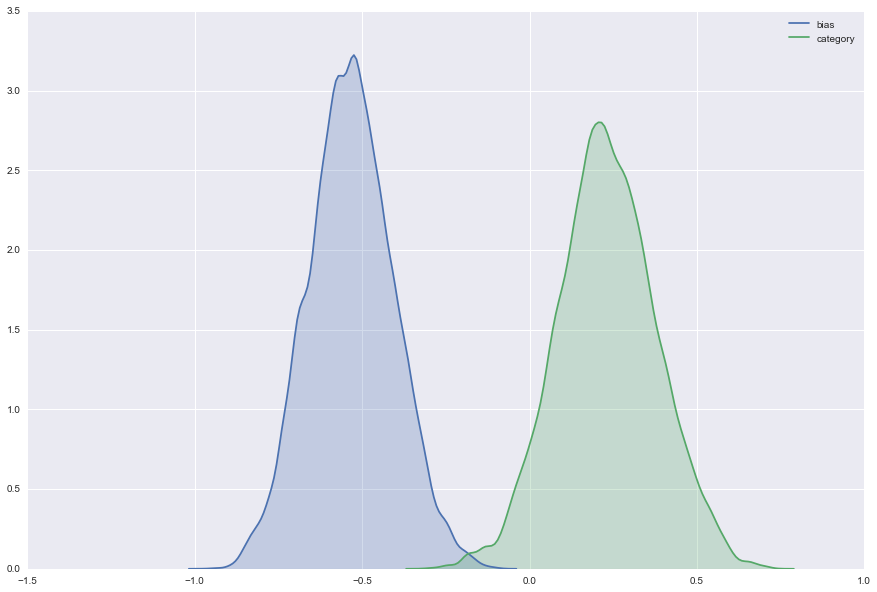

In [11]:
posteriors = [mcmc.trace('alpha_bias')[:][:, 0], ]
for i in range(x.shape[1]):
    posteriors.append(mcmc.trace('alpha')[:][:,i])
    
fig = plt.figure(figsize=(15, 10))
for posterior, name in zip(posteriors, names):
    sns.kdeplot(posterior, shade=True, label=name)

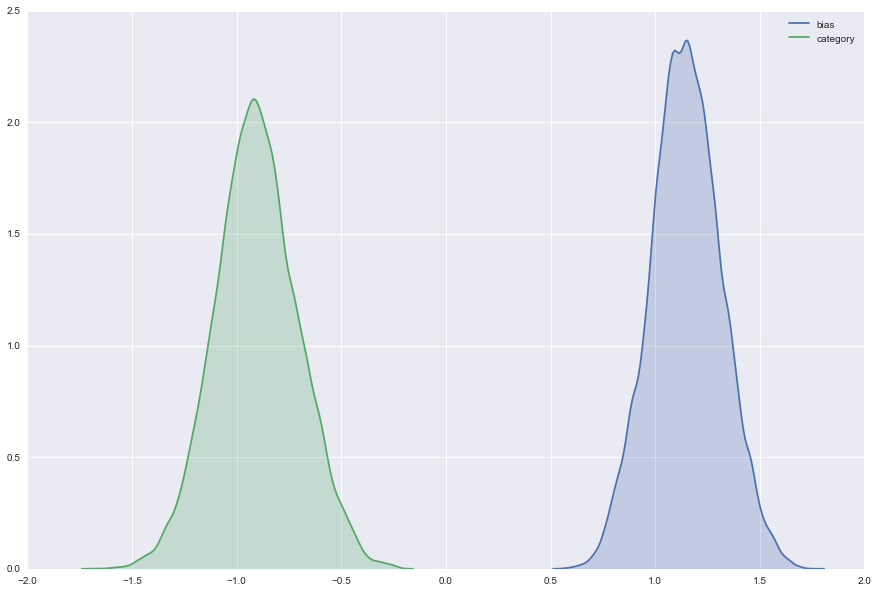

In [12]:
posteriors = [mcmc.trace('beta_bias')[:][:, 0], ]
for i in range(x.shape[1]):
    posteriors.append(mcmc.trace('beta')[:][:,i])
    
fig = plt.figure(figsize=(15, 10))
for posterior, name in zip(posteriors, names):
    sns.kdeplot(posterior, shade=True, label=name)

In [13]:
am = np.concatenate((np.percentile(mcmc.trace('alpha_bias')[:], q=50, axis=0), 
                     np.percentile(mcmc.trace('alpha')[:], q=50, axis=0)))
bm = np.concatenate((np.percentile(mcmc.trace('beta_bias')[:], q=50, axis=0), 
                     np.percentile(mcmc.trace('beta')[:], q=50, axis=0)))

In [14]:
print am
print bm

[-0.53421738  0.22726443]
[ 1.14599257 -0.90843747]


In [15]:
print_stats([0])
for i in range(1, len(am)):
    print_stats([0, i])

bias_           0.586127825538 3.14556200123 0.157067669808
bias_category_  0.735685214259 1.26814487246 0.367139519032


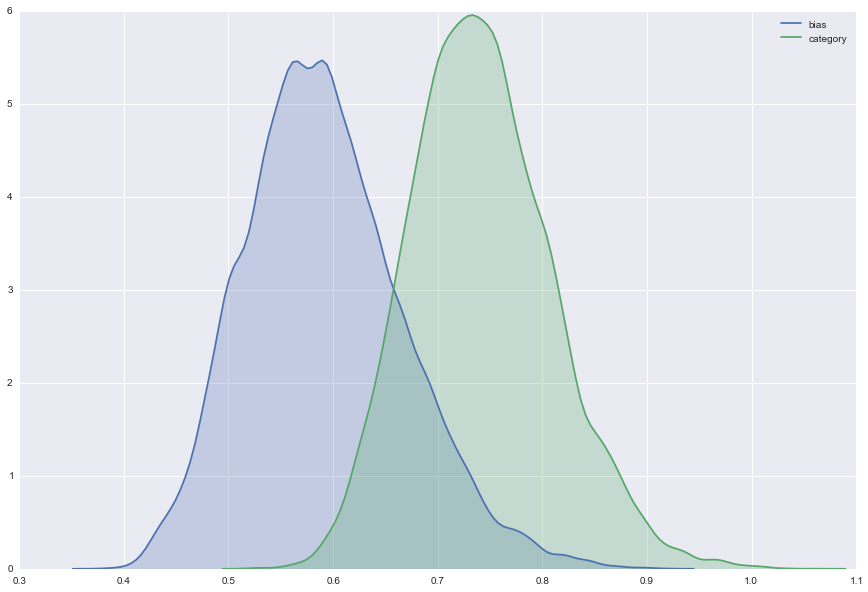

In [16]:
posteriors = [np.exp(mcmc.trace('alpha_bias')[:][:, 0]), ]

for i in range(x.shape[1]):
    posteriors.append(np.exp(mcmc.trace('alpha_bias')[:][:, 0] + mcmc.trace('alpha')[:][:,i])
                      )
    
fig = plt.figure(figsize=(15, 10))
for posterior, name in zip(posteriors, names):
    sns.kdeplot(posterior, shade=True, label=name)

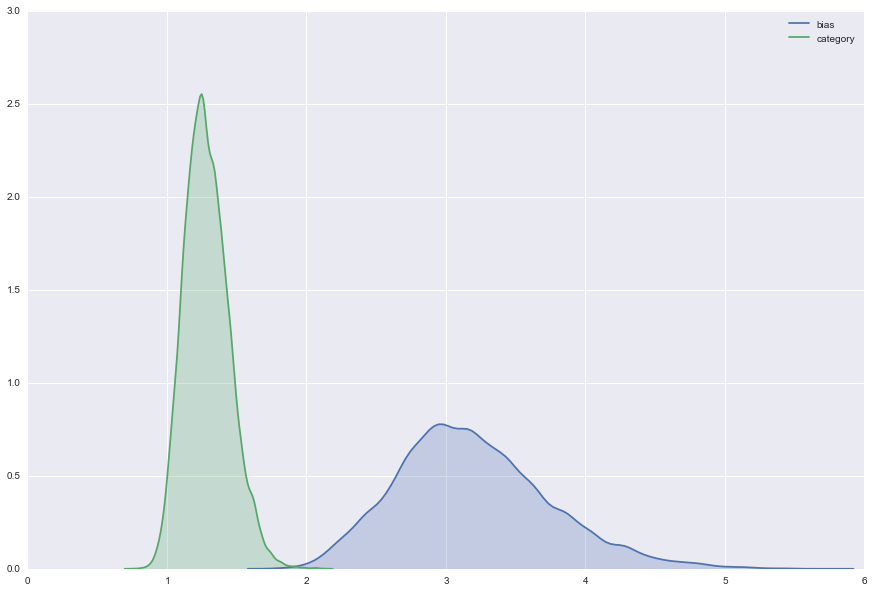

In [17]:
posteriors = [np.exp(mcmc.trace('beta_bias')[:][:, 0]), ]

for i in range(x.shape[1]):
    posteriors.append(np.exp(mcmc.trace('beta_bias')[:][:, 0] + mcmc.trace('beta')[:][:,i])
                      )
    
fig = plt.figure(figsize=(15, 10))
for posterior, name in zip(posteriors, names):
    sns.kdeplot(posterior, shade=True, label=name)